# Lake tables - EFAS6
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 19-11-2024<br>

**Introduction:**<br>
This notebook extracts the attributes required by LISFLOOD for the lakes selected to be modelled in EFAS6:

* Lake area
* Outlet width
* Average inflow

**To do:**
* [ ] Why are there 240 lakes in the EFAS5 attribute tables, but only 203 in the map?
* [ ] There are 4 cases in the selection of lakes for EFAS6 that are actually a controlled lake with an assigned GRanD ID. Check the degree of regulation for final check whether these lakes should be modelled as lakes or reservoirs.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from tqdm.notebook import tqdm
from shapely.geometry import Point
from pathlib import Path
import yaml
from scipy.optimize import curve_fit

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from lisfloodreservoirs.utils.utils import filter_domain, filter_reservoirs, find_connections, remove_duplicates, upstream_pixel, downstream_pixel
from lisfloodreservoirs.utils.plots import plot_reservoir_map

In [2]:
from utils import outlet_width

In [3]:
def compare_attributes(df, thr, vmin, vmax, **kwargs):
    """Pair plot comparing the attribute values in different data sources
    
    Parameters:
    -----------
    df: pandas.DataFrame
        Values of an attributes in different data sources (columns)
    thr: float
        Minimum value of the attribute used in the selection
    vmin: float
        Minimum attribute value to be plotted
    vmax: float
        Maximum attribute value to be plotted
    """
    
    figsize = kwargs.get('figsize', (4, 4))
    
    cols = df.columns
    ncols = len(cols) - 1
    
    fig, ax = plt.subplots(ncols=ncols, nrows=ncols, figsize=(ncols * figsize[0], ncols * figsize[1]), sharex=True, sharey=True)

    for j, colx in enumerate(cols[:-1]):
        for i, coly in enumerate(cols[1:]):
            if j > i:
                ax[i, j].axis('off')
                continue
            ax[i, j].plot([vmin, vmax], [vmin, vmax], c='k', lw=.5, zorder=0)
            ax[i, j].vlines(thr, vmin, thr, color='k', ls='--', lw=.5, zorder=0)
            ax[i, j].hlines(thr, vmin, thr, color='k', ls='--', lw=.5, zorder=0)
            ax[i, j].scatter(df[colx], df[coly], s=10, alpha=.5)
            ax[i, j].set_xscale('log')
            ax[i, j].set_yscale('log')
            if j == 0:
                ax[i, j].set_ylabel(coly)
            if i == ncols - 1:
                ax[i, j].set_xlabel(colx)

            ax[i, j].set(
                xlim=(vmin, vmax),
                ylim=(vmin, vmax),
            );
    
    if 'title' in kwargs:
        ax[0, 1].set_title(kwargs['title']);

In [4]:
def width_from_area(area: float, c: float) -> float:
    """Estimation of the river width based on catchment area:
            width = area**c
    
    Parameters:
    -----------
    area: float
        catchment area in km2
    c: float
        coefficient of the model
        
    Returns:
    --------
    width: float
        river width in meters
    """
    return area**c

## Configuration

In [5]:
# paths
PATH_EFAS5 = Path('Z:/nahaUsers/casadje/EFASv5')
PATH_DATASETS = Path('Z:/nahaUsers/casadje/datasets/')
PATH_EFAS6 = PATH_DATASETS / 'lakes' / 'EFASv6' #Path('../results/reservoirs/selection/EFAS/')
PATH_GLWD = PATH_DATASETS / 'lakes' / 'GLWD'
PATH_HYLAK = PATH_DATASETS / 'lakes' / 'HydroLAKES' / 'LakeATLAS_v10_shp'
PATH_OUT = PATH_EFAS6 / 'tables'
PATH_OUT.mkdir(parents=True, exist_ok=True)

# # minimum storage capacity included in EFAS
MIN_VOLUME = 10 # hm³
MIN_AREA = 5 # km²
MIN_CATCHMENT = 50 # km²
# MIN_DOR = 30 # days

## DATA

### EFAS5

In [6]:
# load EFAS5 lakes
efas5 = gpd.read_file(PATH_EFAS5 / 'tables' / 'EFAS5_lakes.shp').set_index('LakID', drop=True)

# add attributes from the tables
if 'efas_attrs' in locals():
    del efas_attrs
prefix = 'lake'
for file in (PATH_EFAS5 / 'tables').glob(f'{prefix}*.txt'):
    var = file.stem.removeprefix(prefix)
    try:
        df = pd.read_csv(file, sep=' ', header=None)
        df.dropna(axis=1, how='all', inplace=True)
        df.columns = ['LakID', var]
        df.set_index('LakID', inplace=True, drop=True)
        efas5[var] = df
    except:
        print(file)
        continue
# convert area to km2
efas5['area'] /= 1e6
efas5.rename(columns={'a': 'alpha'}, inplace=True)
efas5.drop(['AREA_KM2', 'LON_ORG', 'LAT_ORG', 'LISFLOODX', 'LISFLOODY'], axis=1, inplace=True)

In [7]:
efas5.SOURCE.value_counts()

GLWD1         144
GLWD2          50
GranD           7
Burek_Lake      1
GLOFAS-R        1
Name: SOURCE, dtype: int64

### EFAS6

In [8]:
# import shapefile
efas6 = gpd.read_file('Z:/H07_Global/GloFAS/data/reservoir and lakes EFAS Glofas 2024/LakesEfasV6.shp')

# keep only selected lakes
efas6 = efas6[efas6.checked != 3]

# select columns
id_cols = ['LakID', 'GLWD_ID', 'Hylak_id']
efas6 = efas6[id_cols + ['geometry']]

# remove IDs equal to 0
for col in ['LakID', 'Hylak_id', 'GLWD_ID']:
    efas6[col] = efas6[col].astype('Int64')
    efas6.loc[efas6[col] == 0, col] = np.nan
    
# efas6.columns = [col.upper() if col != 'geometry' else col for col in efas6.columns]

# correct HydroLakes IDs
with open('lakes_EFAS5_HydroLakes.yaml', 'r') as file:
    map_efas_hylak = yaml.safe_load(file)
correct_hylak_ids = efas6.LakID.map(map_efas_hylak).astype('Int64').dropna()
efas6.loc[correct_hylak_ids.index, 'Hylak_id'] = correct_hylak_ids.values

# add GLWD IDs
with open('lakes_EFAS5_GLWD.yaml', 'r') as file:
    map_efas_glwd = yaml.safe_load(file)
correct_glwd_ids = efas6.LakID.map(map_efas_glwd).astype('Int64').dropna()
efas6.loc[correct_glwd_ids.index, 'GLWD_ID'] = correct_glwd_ids.values

efas6.sort_values(['Hylak_id'], ascending=True, inplace=True)
efas6.reset_index(drop=True, inplace=True)
efas6.index.name = 'FID'
print('{0} lakes in EFAS6'.format(efas6.shape[0]))
print('\t* {0} were in EFAS5'.format(efas6.LakID.notnull().sum()))
print('\t* {0} are in HydroLakes'.format(efas6.Hylak_id.notnull().sum()))
print('\t* {0} are in GLWD'.format(efas6.GLWD_ID.notnull().sum()))

214 lakes in EFAS6
	* 120 were in EFAS5
	* 214 are in HydroLakes
	* 119 are in GLWD


In [9]:
points = pd.concat((efas6.geometry.x, efas6.geometry.y), axis=1)
points.columns = ['lon', 'lat']
points.index.name = 'ID'

points.to_csv(PATH_EFAS6 / 'ncextract' / f'lakes_efas6_{efas6.shape[0]}.csv')

### GLWD

In [10]:
# level 1
glwd1 = gpd.read_file(PATH_GLWD / 'level1' / 'glwd_1.shp').set_index('GLWD_ID', drop=True)
glwd1 = glwd1.loc[glwd1.index.intersection(efas6.GLWD_ID)]

# level 2
glwd2 = gpd.read_file(PATH_GLWD / 'level2' / 'glwd_2.shp').set_index('GLWD_ID', drop=True)
glwd2 = glwd2.loc[glwd2.index.intersection(efas6.GLWD_ID)]

# concatenate
glwd = pd.concat((glwd1, glwd2), axis=0)

if not glwd.shape[0] == efas6.GLWD_ID.notnull().sum():
    print('The number of lakes in "glwd" does not match the number of lakes in "efas6" with assigned GLWD_ID')

### HydroLakes

In [11]:
hylak = gpd.read_file(PATH_EFAS6 / 'hydrolakes_domain.shp').set_index('Hylak_id', drop=True)
hylak = hylak.loc[hylak.index.intersection(efas6.Hylak_id)]
hylak.Grand_id = hylak.Grand_id.replace(0, np.nan).astype('Int64')

if not hylak.shape[0] == efas6.Hylak_id.nunique():
    print('The number of lakes in "hylak" ({0}) does not match the number of lakes in "efas6" with assigned Hylak_id ({1})'.format(hylak.shape[0], efas6.Hylak_id.nunique()))

In [12]:
hylak.Lake_type.value_counts()

1    207
3      4
Name: Lake_type, dtype: int64

There are 4 lakes in the selection which are considered as controlled lakes by HydroLakes, therefore, they have a `GRAND_ID` that I will add to the `efas6` table.

In [13]:
# add GRAND_ID to lakes in EFAS6
efas6['GRAND_ID'] = efas6.Hylak_id.map(hylak.Grand_id)

## Attributes

### Lake area

In [14]:
area = pd.DataFrame(index=efas6.index, columns=['EFAS5', 'GLWD', 'HYLAK', 'EFAS6', 'SOURCE'], dtype=float)
area.SOURCE = area.SOURCE.astype(str)

# EFAS5
idx = efas6[efas6.LakID.notnull()].LakID
area.loc[idx.index, 'EFAS5'] = efas5.loc[idx.values, 'area'].values

# GLWD
idx = efas6[efas6.GLWD_ID.notnull()].GLWD_ID
area.loc[idx.index, 'GLWD'] = glwd.loc[idx.values, 'AREA_SKM'].values

# HydroLakes
idx = efas6[efas6.Hylak_id.isin(hylak.index)].Hylak_id
# idx = efas6[efas6.Hylak_id.notnull()].Hylak_id
area.loc[idx.index, 'HYLAK'] = hylak.loc[idx.values, 'Lake_area'].values

In [15]:
area.isnull().sum()

EFAS5      94
GLWD       95
HYLAK       0
EFAS6     214
SOURCE      0
dtype: int64

#### Comparison

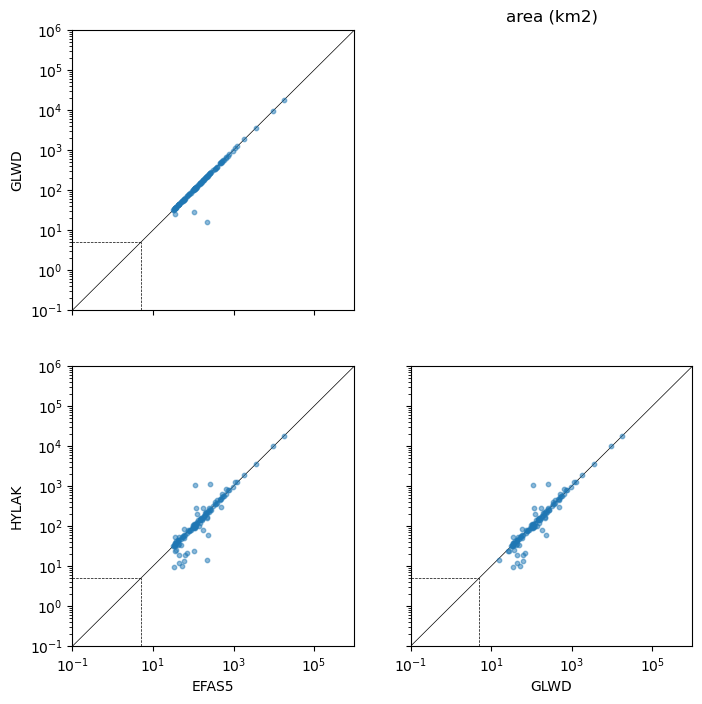

In [16]:
compare_attributes(
    area[['EFAS5', 'GLWD', 'HYLAK']],
    thr=MIN_AREA,
    vmin=1e-1,
    vmax=1e6,
    title='area (km2)'
)

#### Select values

Some `Hylak_id` are repeated in EFAS6 because HydroLakes considers as a single lake cases where GLWD (and therefore EFAS5) considers several lakes. Therefore, using the HYLAK value will overestimate total area. I will use as main source GLWD, then EFAS5 and lastly HYLAK.

In [17]:
# select value from GRAND, EFAS5, HYLAK or ICOLD in that order
for source in ['GLWD', 'EFAS5', 'HYLAK']:
    missing = area.EFAS6.isnull()
    mask = area[source].notnull()
    area.loc[missing & mask, 'EFAS6'] = area.loc[missing & mask, source]
    area.loc[missing & mask, 'SOURCE'] = source

# add values to EFAS6
efas6.loc[area.index, ['AREA_SKM', 'AREA_SRC']] = area[['EFAS6', 'SOURCE']].values

print('{0} lakes do not comply with the minimum lake area of {1} km2'.format((efas6.AREA_SKM < MIN_AREA).sum(),
                                                                             MIN_AREA))

0 lakes do not comply with the minimum lake area of 5 km2


### $\alpha$: width of the outlet

In [18]:
alpha = pd.DataFrame(index=efas6.index, columns=['EFAS5', 'BUREK', 'EXP', 'CHANBW', 'EFAS6', 'SOURCE'], dtype=float)
alpha.SOURCE = alpha.SOURCE.astype(str)

# EFAS5
idx = efas6[efas6.LakID.notnull()].LakID
alpha.loc[idx.index, 'EFAS5'] = efas5.loc[idx.values, 'alpha'].values

# using Burek's formula
uparea = rxr.open_rasterio(PATH_EFAS5 / 'static_maps' / 'upArea_European_01min.nc').squeeze(dim='band')
for ID, point in tqdm(efas6.geometry.items(), total=efas6.shape[0], desc='catchment area'):
    efas6.loc[ID, 'CATCH_SKM'] = int(uparea.sel(x=point.x, y=point.y, method='nearest').item() / 1e6)
alpha['BUREK'] = efas6.CATCH_SKM * 0.0032

# fit a exponential function to the EFAS5 data
aux = efas5[efas5.alpha != efas5.alpha.min()]
params, covariance = curve_fit(width_from_area, aux.CATCH_AREA, aux.alpha, p0=[.5])
print('c = {0:.2f}'.format(params[0]))
alpha['EXP'] = width_from_area(efas6.CATCH_SKM, c=params[0])

# channel width
chanbw = rxr.open_rasterio(PATH_EFAS5 / 'static_maps' / 'chanbw_European_01min.nc').squeeze(dim='band')
chanbw = chanbw.where(chanbw >= 0, np.nan)
for ID, point in tqdm(efas6.geometry.items(), total=efas6.shape[0], desc='channel width'):
    alpha.loc[ID, 'CHANBW'] = outlet_width(chanbw, uparea, point.x, point.y, n_points=3)

catchment area:   0%|          | 0/214 [00:00<?, ?it/s]

c = 0.55


channel width:   0%|          | 0/214 [00:00<?, ?it/s]

Failed to find downstream pixel: numpy.nanmax raises on a.size==0 and axis=None; So Bottleneck too.
Failed to find downstream pixel: numpy.nanmax raises on a.size==0 and axis=None; So Bottleneck too.
Failed to find downstream pixel: numpy.nanmax raises on a.size==0 and axis=None; So Bottleneck too.


#### Comparison 

In [19]:
# fig, axes = plt.subplots(ncols=3, figsize=(10, 3), sharex=True, sharey=True)

# vmin, vmax = .01, 1000
# for ax, col in zip(axes, ['CHANBW', 'BUREK', 'EXP']):
#     ax.scatter(alpha[col], alpha.EFAS5, s=8, alpha=.5)
#     ax.plot([vmin, vmax], [vmin, vmax], 'k', lw=.5, zorder=0)
#     ax.set(
#         xlabel=col,
#         xscale='log',
#         yscale='log'
#     )
#     if ax == axes[0]:
#         ax.set_ylabel('EFAS5')
#         ax.set(
#             xlim=(vmin, vmax),
#             ylim=(vmin, vmax)
#         )

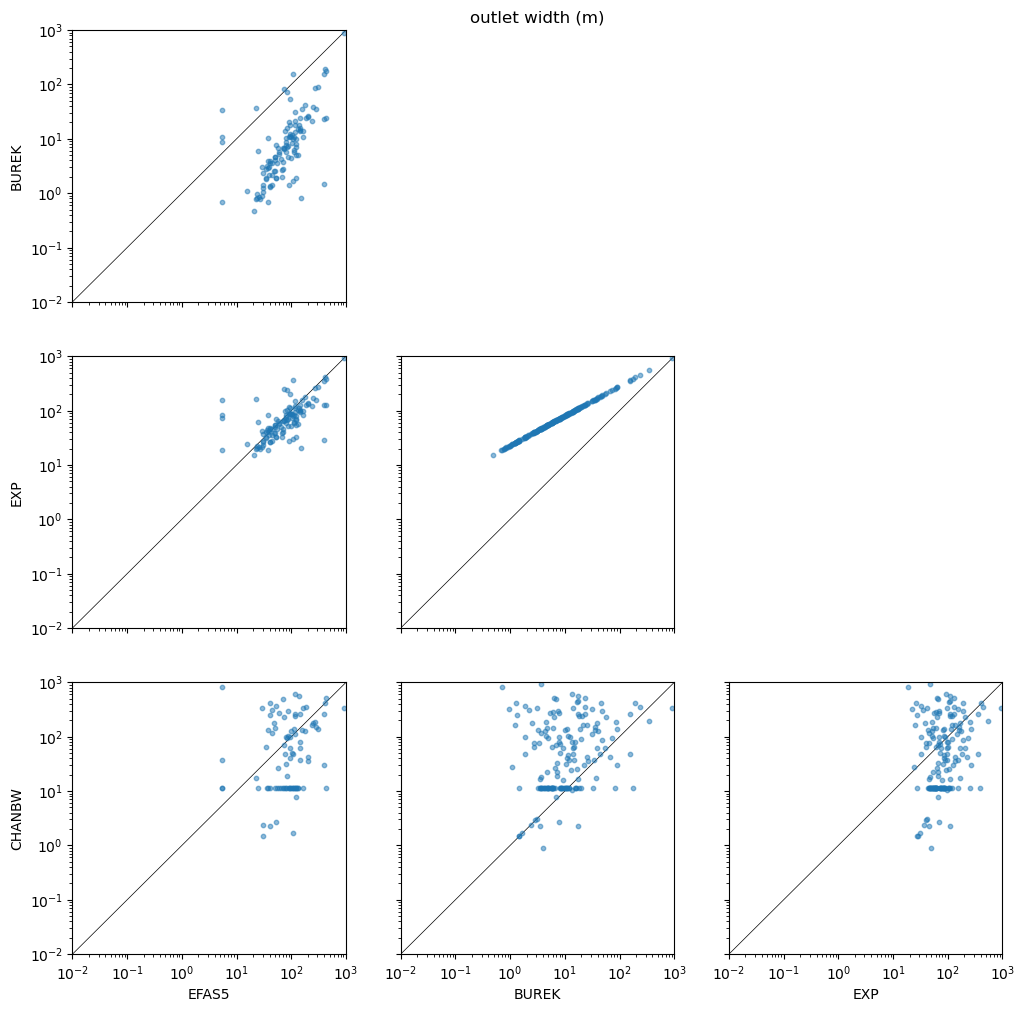

In [20]:
compare_attributes(
    alpha[['EFAS5', 'BUREK', 'EXP', 'CHANBW']],
    thr=0,
    vmin=0.01,
    vmax=1000,
    title='outlet width (m)'
)

#### Select values
I select EFAS5 values, if possible. If not, I will use the exponential function.

In [21]:
# select value from GRAND, EFAS5, HYLAK or ICOLD in that order
for source in ['EFAS5', 'EXP']:
    missing = alpha.EFAS6.isnull()
    mask = alpha[source].notnull()
    alpha.loc[missing & mask, 'EFAS6'] = alpha.loc[missing & mask, source]
    alpha.loc[missing & mask, 'SOURCE'] = source

# add values to EFAS6
efas6.loc[alpha.index, ['WIDTH_M', 'WIDTH_SRC']] = alpha[['EFAS6', 'SOURCE']].values

### Average inflow

In [22]:
avg_inflow = pd.DataFrame(index=efas6.index, columns=['EFAS5', 'NAT_FLOW', 'GLWD', 'HYLAK', 'EFAS6', 'SOURCE'], dtype=float)
avg_inflow.SOURCE = alpha.SOURCE.astype(str)

# EFAS5
idx = efas6[efas6.LakID.notnull()].LakID
avg_inflow.loc[idx.index, 'EFAS5'] = efas5.loc[idx.values, 'avinflow'].values

# EFAS5 naturalised long-term run 
dis = xr.open_dataset(PATH_EFAS6 / 'ncextract' / 'dis_215.nc')['dis']
dis = dis.sel(time=slice('1993-01-02', None))
dis.close()
avg_inflow['NAT_FLOW'] = dis.mean('time').to_pandas()

# GLWD
idx = efas6[efas6.GLWD_ID.notnull()].GLWD_ID
avg_inflow.loc[idx.index, 'GLWD'] = glwd.loc[idx.values, 'INFLOW_CMS'].values

# HydroLakes
idx = efas6[efas6.Hylak_id.isin(hylak.index)].Hylak_id
avg_inflow.loc[idx.index, 'HYLAK'] = hylak.loc[idx.values, 'Dis_avg'].values

#### Comparison

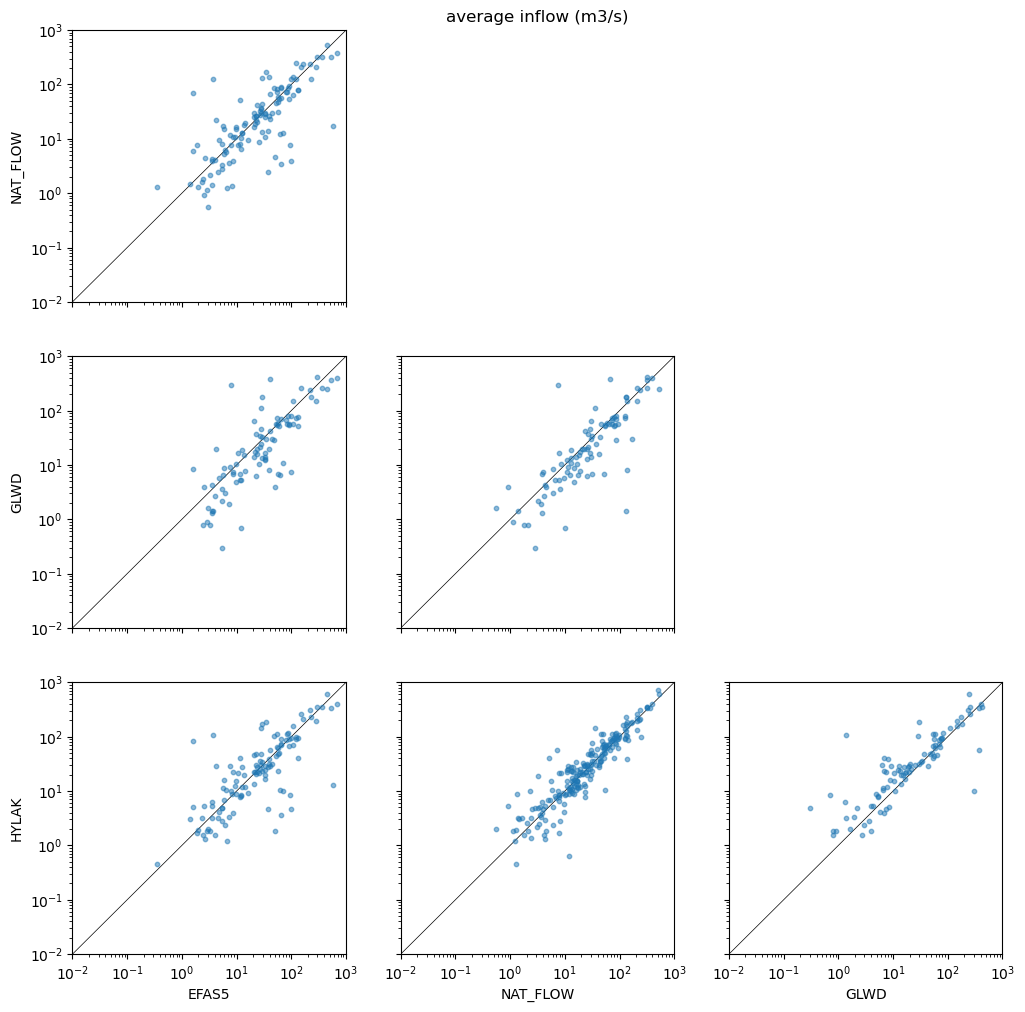

In [23]:
compare_attributes(
    avg_inflow[['EFAS5', 'NAT_FLOW', 'GLWD', 'HYLAK']],
    thr=0,
    vmin=0.01,
    vmax=1000,
    title='average inflow (m3/s)'
)

#### Select value

I will select in all cases the value from the EFAS5 naturalised run.

In [24]:
avg_inflow.EFAS6 = avg_inflow.NAT_FLOW
avg_inflow.SOURCE = 'EFAS5_nat_flow' 

# add values to EFAS6
efas6.loc[alpha.index, ['INFLOW_CMS', 'INFLOW_SRC']] = avg_inflow[['EFAS6', 'SOURCE']].values

## Export

In [25]:
# add coordinates in the LISFLOOD grid
efas6['LisfloodX'] = efas6.geometry.x
efas6['LisfloodY'] = efas6.geometry.y

In [27]:
# round to 1 or 0 decimals
efas6[['AREA_SKM', 'WIDTH_M', 'INFLOW_CMS']] = efas6[['AREA_SKM', 'WIDTH_M', 'INFLOW_CMS']].round(1)
efas6['CATCH_SKM'] = efas6['CATCH_SKM'].astype(int)

In [29]:
# export as shapefile
efas6.to_file(PATH_OUT / 'efas6_lakes.shp')

In [31]:
PATH_OUT

WindowsPath('Z:/nahaUsers/casadje/datasets/lakes/EFASv6/tables')

In [33]:
# export as CSV
efas6.drop('geometry', axis=1).to_csv(PATH_OUT / 'efas6_lakes.csv')